<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/02_traditional_rag_vs_agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the difference between Traditional RAG (Retrieval Augmented Generation) and Agentic RAG.

In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 113 (delta 59), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 1.06 MiB | 8.09 MiB/s, done.
Resolving deltas: 100% (59/59), done.


## Install Required Packages

In [ ]:
!pip install -r /content/Agentic_KAG/requirements.txt -q

## Load credentials from .env

In [ ]:
import os
os.chdir('/content/Agentic_KAG/')

from dotenv import load_dotenv

load_dotenv()  # This loads .env at project root

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set OPENAI_API_KEY as env variable for openai/neo4j-graphrag compatibility
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Initialize OpenAI LLM and Embeddings via langchain_openai
We will use OpenAI **GPT models** and **text-embedding-3-small** for the embedding model.

In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Initialize OpenAI LLM using LangChain
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model_name="gpt-4.1",
                 temperature=0)

# Initialize OpenAI Embedding model using LangChain
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY,
                              model="text-embedding-3-small")

# Indexing

## Load data

Load the data from the `page_data.pkl` file. This contains all the crawled DHS 2025 pages in a markdown format.


In [ ]:
import pickle
with open("page_data.pkl", "rb") as f:
    pages = pickle.load(f)

## Create langchain documents

Convert the loaded data into LangChain `Document` objects.


In [ ]:
from langchain_core.documents import Document

documents = [] # Initialize an empty list to store LangChain Document objects.
for page in pages: # Iterate through each page in the 'pages' list.
    # Create a Document object for each page.
    # 'page_content' is set to the content of the page, and 'metadata' includes the page's URL.
    doc = Document(page_content=page['content'], metadata={'url': page['url']})
    documents.append(doc) # Add the created Document object to the 'documents' list.

print(f"Created {len(documents)} LangChain documents.") # Print the total number of documents created.

Created 81 LangChain documents.


In [ ]:
pages[0]

{'url': 'https://www.analyticsvidhya.com/datahacksummit',
 'content': "# The AI Trinity\n\n## Powering the Future\n\n### Generative | Agentic | Responsible\n\n## India's Most Futuristic AI Conference\n\n### August 20-23, 2025  • The Leela Bhartiya City Bengaluru \n\nSend WhatsApp Updates\n\nDownload Agenda\n\nYour browser does not support the video tag. \n\n## 1200+\n\n### Attendees\n\n## 80+\n\n### AI Talks\n\n## 50+\n\n### Hack Sessions\n\n## 10+\n\n### Workshops\n\n## Hands-on AI Workshops\n\n### [Mastering Intelligent Agents: A Deep Dive into Agentic AI Dipanjan Sarkar - Analytics Vidhya  ](/datahacksummit-2025/workshops/mastering-intelligent-agents-a-deep-dive-into-agentic-ai-building-ai)\n\n[ 🔥 Most Trending Mastering Real-World Multi-Agent Systems Alessandro Romano - Kuehne+Nagel  ](/datahacksummit-2025/workshops/build-a-production-ready-multi-agent-application-with-crewai)\n\n[ Almost Sold Out Mastering Real-World Agentic AI Applications with AG2 (AutoGen) Hrushikesh Dokala - A

## Create Custom Metadata Chunks

* 1 webpage or URL = 1 Chunk
* Enhance the metadata of each chunk b including a custom MD tag from the DHS webpages to easily classify the chunks as 'Session' or 'Speaker' or 'Workshop' and the likes

In [ ]:
from urllib.parse import urlparse

def extract_section_from_url(url: str) -> str:
    """
    Extracts the main section name from a given URL.

    Args:
        url: The URL string from which to extract the section.

    Returns:
        A string representing the main section of the URL,
        or "Overview" if no specific section is identified.
    """
    path = urlparse(url).path
    parts = [p for p in path.strip("/").split("/") if p]

    if "datahacksummit-2025" in parts:
        parts.remove("datahacksummit-2025")

    if parts:
        return parts[0].replace("-", " ").title()
    else:
        return "Overview"

for item in documents:
  section = extract_section_from_url(item.metadata["url"])
  item.metadata['section'] = section

In [ ]:
documents[77]

Document(metadata={'url': 'https://www.analyticsvidhya.com/datahacksummit-2025/speakers/nitin-agarwal', 'section': 'Speakers'}, page_content="# Nitin Agarwal [ ](https://www.linkedin.com/in/agnitin/)\n\nPrincipal Data Scientist\n\nNitin is an accomplished Data Science leader with 14 years of experience at the intersection of Generative AI, Large Language Models, Machine Learning, and advanced analytics. He brings deep expertise in designing and deploying AI copilots that seamlessly integrate cutting-edge technology with user-centric design, driving measurable impact at scale. His work spans the full AI spectrum--from classical ML systems to state-of-the-art GenAI solutions--transforming how users engage with intelligent technology.\n\nRead more\n\n##  Hack Sessions\n\nUnderstanding AI Agents with MCP\n\nNitin Agarwal\n\nPrincipal Data Scientist\n\nRutvik Acharya\n\nPrincipal Data Scientist\n\nThis session introduces the **Model Context Protocol (MCP)** , an open standard developed by A

## Create vector store

Create a vector store from the document chunks and the initialized embeddings.
We save this vector store in a persistent directory so that we can use it in future.


In [ ]:
from langchain_community.vectorstores import Chroma

persist_directory = os.getcwd() +'/vectorstore/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory
)

print(vectordb._collection.count())

81


# RAG Retrieval Pipeline

![](https://substackcdn.com/image/fetch/$s_!nnE0!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fc60f8ecc-af83-4c9d-90dd-2c58aca92c3c_1456x609.gif)


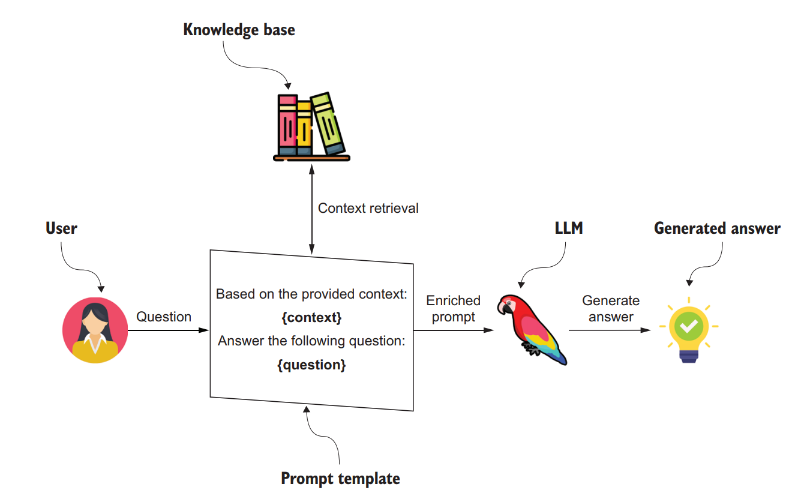

## Retrieval

Once the vector database is populated, you can define it as the retriever component, which fetches the additional context based on the semantic similarity between the user query and the embedded chunks.

To implement hybrid search with ChromaDB in LangChain, we combine vector similarity search and traditional keyword searches (like BM25) using an ensemble technique. Although ChromaDB itself does not have built-in hybrid search, LangChain allows you to blend different retrievers to achieve this effect.

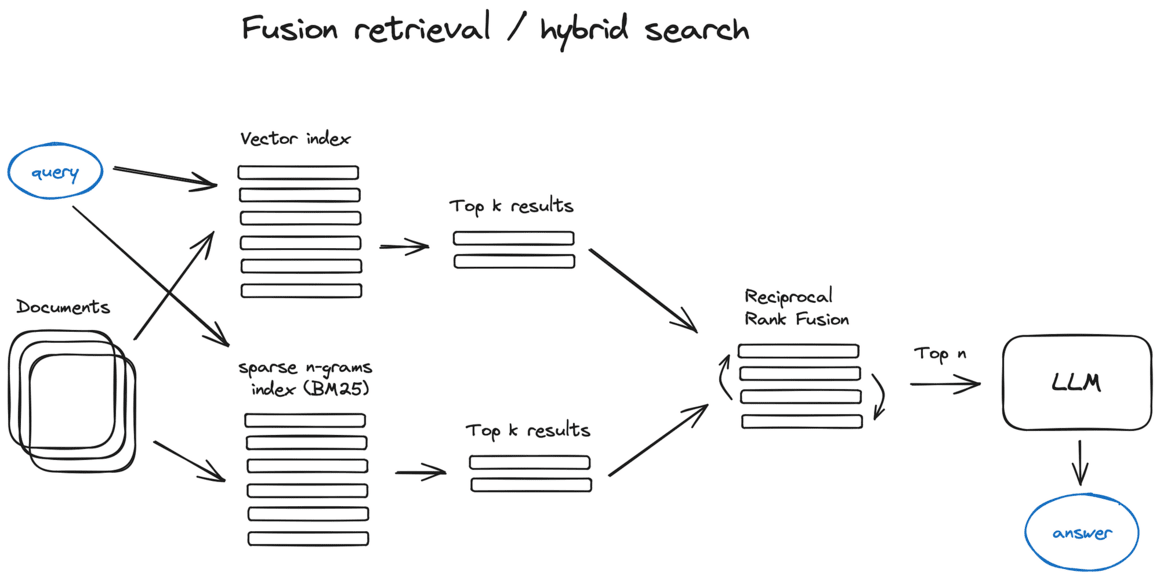

In [ ]:
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

#Initialize ChromaDB Vector Store (Dense/Semantic Retriever)
similarity_search_retriever = vectordb.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 5})

#Prepare BM25 Retriever (Keyword/Sparse Retriever)
bm25_retriever = BM25Retriever.from_documents(documents=documents, k=5)


#Create an Ensemble Retriever:Combine both the semantic (vector) and keyword (BM25) retrievers using EnsembleRetriever.
ensemble_retriever = EnsembleRetriever(
    retrievers=[similarity_search_retriever, bm25_retriever],
    weights=[0.5, 0.5]
)

## Augmentation
Next, to augment the prompt with the additional context, you need to prepare a prompt template. The prompt can be easily customized from a prompt template, as shown below.

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Avoid using generic phrases like "Provide context" or "as per context.

Question: {input}

Context: {context}

Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

## Generation
Finally, you can build a chain for the RAG pipeline, chaining together the retriever, the prompt template and the LLM. Once the RAG chain is defined, you can invoke it.

* `create_stuff_documents_chain(llm, prompt)`: This creates a chain that takes a list of documents and a prompt, formats the documents into the prompt, and then passes the prompt to the language model (llm) to generate an answer.

* `create_retrieval_chain(ensemble_retriever, combine_docs_chain)`: This creates the main RAG chain. It takes the ensemble_retriever (which retrieves relevant documents based on the input question) and the combine_docs_chain (which formats the retrieved documents and generates an answer using the LLM). When this chain is invoked with a question, it first uses the retriever to get relevant documents and then passes those documents to the combine_docs_chain to generate the final answer.

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Create a chain for passing a list of Documents to a model.
combine_docs_chain = create_stuff_documents_chain(llm, prompt)

# Create a retrieval chain
rag_chain = create_retrieval_chain(ensemble_retriever, combine_docs_chain)

## Test Traditional RAG

Test the traditional RAG implementation with a sample query.

In [ ]:
from IPython.display import Markdown

question = "Which topics are the most frequently covered across all sessions and workshops at DHS 2025?"
response = rag_chain.invoke({"input": question})

Markdown(response["answer"])

The most frequently covered topics at DHS 2025 are Agentic AI (including building, deploying, and operationalizing AI agents), Large Language Models (LLMs) and their training/fine-tuning, and multi-agent systems and orchestration frameworks (such as CrewAI, LangGraph, and AutoGen). Workshops and sessions also emphasize practical aspects like memory management, tool integration, risk mitigation, and real-world deployment of agentic systems. Additional recurring themes include multimodal agents (integrating vision, speech, and language), reasoning models, and governance/observability in AI systems.

In [ ]:
question = "List down all the sessions or workshops which uses LangGraph?"
response = rag_chain.invoke({"input": question})

Markdown(response["answer"])

The following sessions and workshops use LangGraph:

1. Agentic RAG Workshop: From Fundamentals to Real-World Implementations (Arun Prakash Asokan) – hands-on with LangGraph for agent orchestration.
2. Agentic Knowledge Augmented Generation: The Next Leap After RAG (Arun Prakash Asokan) – designing autonomous AI agents using LangGraph.
3. AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks (Panel) – live demo of LangGraph for multi-agent helpdesk AI.
4. Mastering Agentic Workflows with LangGraph (Sanathraj Narayan) – building graph-based LLM workflows with LangGraph.
5. LLMOps – Productionalizing Real-World Applications with LLMs and Agents (Kartik Nighania) – includes modules on multi-agent workflows with LangGraph.
6. AgentOps: Building and Deploying AI Agents (Bhaskarjit Sarmah) – hands-on modules on building agents and multi-agent systems with LangGraph.

## Test Agentic RAG

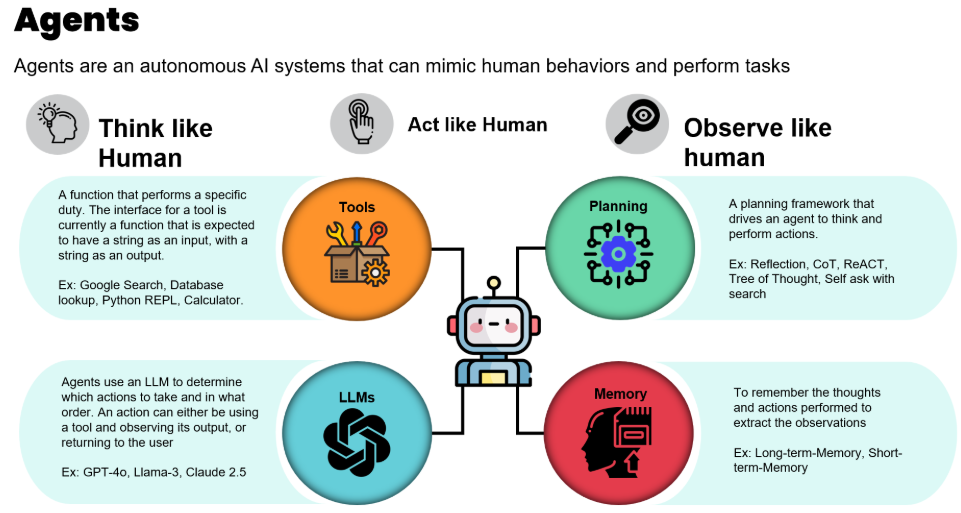

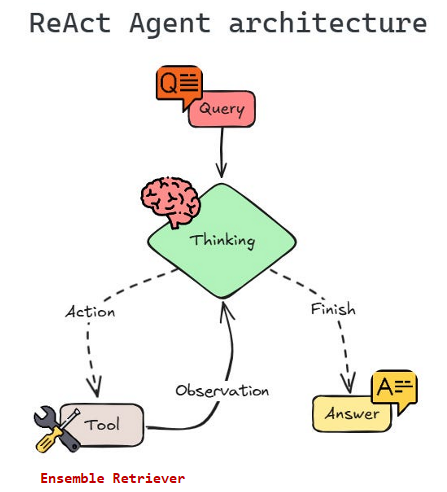

In [ ]:
from langchain.agents import create_react_agent, AgentExecutor
from langchain.tools import Tool
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    HumanMessagePromptTemplate,
    AIMessagePromptTemplate,
    PromptTemplate,
)

In [ ]:
# Let's make a tool out of the Ensemble Retriever
from langchain.tools.retriever import create_retriever_tool

AV_retriever_tool = create_retriever_tool(retriever=ensemble_retriever,
                            name = 'AV_DHS_Retriever',
                            description="Use this tool to answer questions related to related to Analytics Vidhya's DHS 2025")
tools = [AV_retriever_tool]


In [ ]:
# Get the ReAct prompt
prompt = '''
You are an intelligent agent tasked with answering questions by reasoning step-by-step and using tools when necessary. Follow the format precisely.

#### Answering and Formatting Instructions

1. **Markdown Formatting (MANDATORY):**
   - All responses must be formatted in Markdown.
   - Use bold text for all the headers and subheaders.
   - Use bullets, tables wherever applicable.
   - Do not use plain text or paragraphs without Markdown structure.
   - Ensure that you use hyphens (-) for list bullets. For sub-bullets, indent using 2 spaces (not tabs). Ensure proper nesting and consistent formatting.

2. **Citations Must (MANDATORY):**
    - Citations must be immediately placed after the relevant content. Cite relevant URLs as meaningful hyperlinks wherever applicable.
    - Do not place citations at the end or in a separate references section. They should appear directly after the statement being referenced. **Place inline citations immediately after the relevant content**
    - Do not include tool names or retriever names in citations.

Answer the following questions as best you can in a clear markdown format. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: [tool name] - should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}'''


In [ ]:
# Create the ReAct agent
def get_react_agent(llm, tools, system_prompt, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="conversation_history", optional=True),
            HumanMessagePromptTemplate(
                prompt=PromptTemplate(input_variables=["input"], template="{input}")
            ),
            AIMessagePromptTemplate(
                prompt=PromptTemplate(
                    input_variables=["agent_scratchpad"], template="{agent_scratchpad}"
                )
            ),
        ]
    )
    agent = create_react_agent(llm, tools, prompt)
    return AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=verbose,
        stream_runnable=True,
        handle_parsing_errors=True,
        max_iterations=5,
        return_intermediate_steps=True,
    )

generate_agent = get_react_agent(
        llm,
        tools,
        prompt,
        verbose=True,
    )


In [ ]:

question = "Which topics are the most frequently covered across all sessions and workshops at DHS 2025?"
answer = generate_agent.invoke(
            {
                "input": question,
            }
        )
Markdown(answer["output"])

In [ ]:
question = "List down all the sessions or workshops which uses LangGraph??"
answer = generate_agent.invoke(
            {
                "input": question,
            }
        )
Markdown(answer["output"])



> Entering new AgentExecutor chain...
Thought: To answer this, I need to search for sessions or workshops that specifically mention the use of LangGraph.
Action: AV_Agentic_RAG_tool
Action Input: sessions or workshops that use LangGraph[Document(metadata={'url': 'https://www.analyticsvidhya.com/datahacksummit-2025/speakers/arun-prakash-asokan-2', 'section': 'Speakers'}, page_content='Arun Prakash Asokan [ ](https://www.linkedin.com/in/arunprakashasokan/) Associate Director Data Science Arun Prakash Asokan, an esteemed AI thought leader and Intrapreneur, holds over 16 years of experience driving comprehensive AI programs across diverse domains. Recognized as a Scholar of Excellence from the Indian School of Business, he seamlessly integrates academic rigor with practical expertise, holding a Master\'s in Computer Science Engineering from BITS Pilani and completing an Advanced Management Program from ISB Hyderabad. Arun\'s passion for building AI products is evident through his leaders

**Sessions and Workshops Using LangGraph**

---

- **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**
  - Focus: Deep dive into Agentic RAG, building agentic workflows using LangGraph and LangChain.
  - Details: Hands-on modules, practical enterprise-grade tips, and full-scale agentic RAG application.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title)

---

- **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**
  - Focus: End-to-end LLMOps, including multi-agent workflows with LangGraph.
  - Details: Includes a dedicated module and lab on building multi-agent workflows using LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2)

---

- **Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language**
  - Focus: Building a multimodal Telegram agent, managing workflows with LangGraph and LangGraph Studio.
  - Details: Covers agent memory, speech, vision, and real-time integration using LangGraph as the backbone.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)

---

- **Hack Session: Agentic Knowledge Augmented Generation: The Next Leap After RAG**
  - Focus: Building knowledge graphs, using graph databases, and designing autonomous AI agents with LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)

---

- **Hack Session: Mastering Agentic Workflows with LangGraph**
  - Focus: Building graph-based LLM workflows, agent architectures, reflexion loops, and agentic RAG using LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals)

---

- **Hack Panel: AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
  - Focus: Live demos and panel discussion comparing LangGraph with other agent frameworks.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/autogen-vs-crewai-vs-langgraph-battle-of-the-agent-frameworks)

---

- **Hack Session: Beyond PoCs: Building Real-World Agentic Systems**
  - Focus: Fundamentals of agents, Agentic RAG, and productionizing agentic systems using LangGraph.
  - [Read More](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/beyond-pocs-building-real-world-agentic-systems)

---

**Summary Table**

| Session/Workshop Title                                                                 | LangGraph Usage Area                | Link                                                                                                    |
|----------------------------------------------------------------------------------------|-------------------------------------|---------------------------------------------------------------------------------------------------------|
| Agentic RAG Workshop: From Fundamentals to Real-World Implementations                  | Agentic RAG, agent orchestration    | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/agentic-rag-workshop-from-fundamentals-to-real-world-implemenno-title) |
| LLMOps – Productionalizing Real-World Applications with LLMs and Agents                | Multi-agent workflows               | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/llmops-productionalizing-real-world-applications-with-llms-2)          |
| Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language          | Multimodal agent orchestration      | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/workshops/building-a-multimodal-telegram-agent-that-sees-talks-and-thinks)       |
| Agentic Knowledge Augmented Generation: The Next Leap After RAG (Hack Session)         | Knowledge graphs, agent navigation  | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/agentic-knowledge-augmented-generation-the-next-leap-after-rag)         |
| Mastering Agentic Workflows with LangGraph (Hack Session)                              | Agentic workflows, reflexion loops  | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/building-intelligent-workflows-with-langgraph-from-agent-fundamentals)  |
| AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks (Hack Panel)            | Framework comparison, live demo     | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/autogen-vs-crewai-vs-langgraph-battle-of-the-agent-frameworks)          |
| Beyond PoCs: Building Real-World Agentic Systems (Hack Session)                        | Real-world agentic systems          | [Details](https://www.analyticsvidhya.com/datahacksummit-2025/sessions/beyond-pocs-building-real-world-agentic-systems)                        |

---

**All the above sessions and workshops explicitly use LangGraph as a core part of their content or demonstrations.**